
Customer Churn Prediction is the use of data and predictive analytics to foresee which customers are likely to leave, enabling businesses to take preventive actions and enhance customer retention.

# Notebook Content 

## AutoSearch Vs NN
- [1.0- Load Data and Imports](#1.0)
    - [1.1- Import require lib](#1.1)
- [2.0- EDA](#2.0)
    - [2.1- Illustrate the correlation or connection between different columns in the dataset.](#2.1)
- [3.0- Preprocessing Data and Load Model](#3.0)
    - [ 3.1- Preprocessing ](#3.1)
    - [ 3.2- AutoSearch model](#3.2)
    - [ 3.3- Make Prediction](#3.3)
- [4.0- NN Model](#4.0)
    - [ 4.1- Prepare the Data](#4.1)
    - [ 4.2- Create Neural Network Model](#4.2)
    - [ 4.3- Make Prediction](#4.3)


# [1.1- Import require lib](#1.1)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import IPython
import altair as alt 
import warnings
import torch 

from IPython.display import HTML , display , Image
from sklearn.preprocessing import OneHotEncoder , LabelEncoder , StandardScaler 
from sklearn.compose import ColumnTransformer  , make_column_transformer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import cross_val_score , cross_validate , train_test_split , RandomizedSearchCV , KFold
from sklearn.pipeline import make_pipeline ,Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , f1_score, make_scorer, recall_score 

import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import TensorDataset ,  DataLoader




/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Load dataset 

data_path = '/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv'

data      = pd.read_csv(data_path)
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
columns_list = data.columns.tolist()
columns_list

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [4]:
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

# [2.0- EDA](#2.0)

In [5]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
data['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

We have a class imbalance. Both classes seem importance here.
We will be going to use macro-average f1 score as our evaluation metric.

In [7]:
metrics_score =  make_scorer(f1_score , average='macro')
score         = metrics_score

In [8]:
data = data.drop(['RowNumber','CustomerId','Surname'] , axis=1)


As can be seen, column `Age` is the most relavent of colums. lets show the density of each type of `Gender` relavent with `Age` columns

# [2.1- Illustrate the correlation or connection between different columns in the dataset.](#2.1)

In [9]:
Gender_Density = (alt.Chart(data[:5000])
              .transform_density(
                                  'Age' , 
                                   groupby = ['Exited' , 'Gender'] ,
                                   as_     = ['Age' , 'Density'] ,
                                   counts  = True,).mark_line().encode(
                                 x='Age',
                                 y = 'Density:Q',
                                 color= 'Exited:N',
                                 tooltip='Age').facet('Gender',
                                 title = 'Age Density'))
Gender_Density

alt.FacetChart(...)

# [3.0- Preprocessing Data and Load Model](#3.0)

In [10]:
data.tail()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


# [ 3.1- Preprocessing ](#3.1)


### spliting data into train and testsets 

In [11]:
y_label = data['Exited']
data = data.drop(['Exited'] , axis=1)

X_train , X_test , y_train , y_test = train_test_split(data , y_label , test_size=0.2 , random_state=12)


In [12]:
# categorical_columns = ['Geography' ,'Gender' ] 
# scaler_columns    = ['CreditScore' , 'Balance' , 'EstimatedSalary']

Encoder1 = LabelEncoder()
Encoder2 = LabelEncoder()
Scaler_model = StandardScaler()

X_train['Geography'] = Encoder1.fit_transform(X_train['Geography']).tolist()
X_train['Gender']    = Encoder2.fit_transform(X_train['Gender']).tolist()
#########################################
X_test['Geography'] = Encoder1.transform(X_test['Geography']).tolist()
X_test['Gender']    = Encoder2.transform(X_test['Gender']).tolist()

X_train = Scaler_model.fit_transform(X_train)
X_test  = Scaler_model.transform(X_test)
#########################################
X_train = pd.DataFrame(X_train , columns = columns_list[3:-1])
X_test = pd.DataFrame(X_test , columns = columns_list[3:-1])

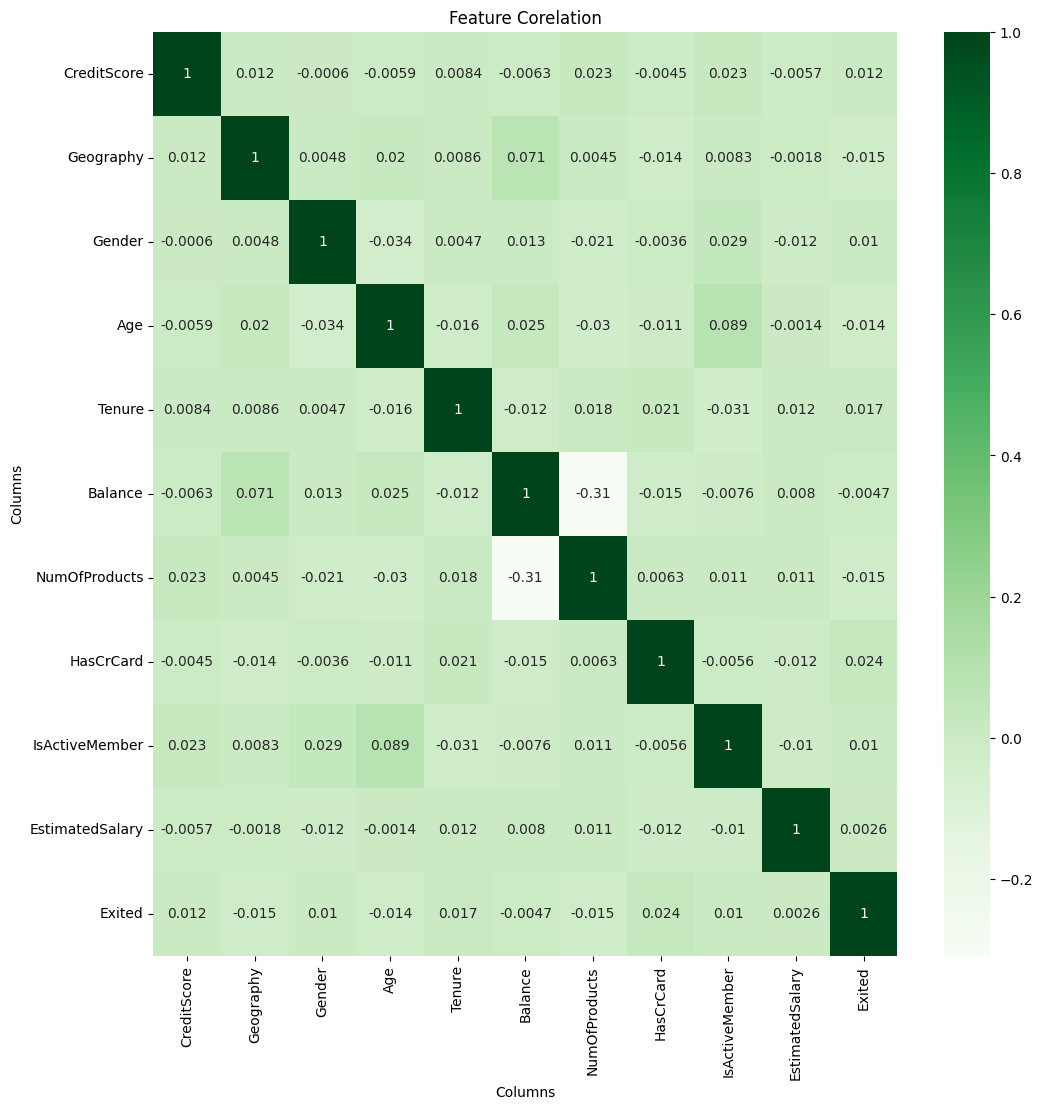

In [13]:
train_data =  X_train.copy()
train_data['Exited'] = y_train



fig , ax = plt.subplots(figsize=(12,12))
sns.heatmap(train_data.corr() , annot= True , ax=ax ,cmap= 'Greens' ).set(title='Feature Corelation' , xlabel='Columns' , ylabel='Columns')
plt.show()

In [14]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.726827,-0.896810,0.910259,0.198761,0.681383,-1.228576,0.809391,-1.546837,0.966801,-0.676707
1,0.932858,-0.896810,-1.098588,-0.277114,-0.704157,-1.228576,0.809391,0.646480,0.966801,-0.176273
2,-0.725691,-0.896810,0.910259,1.055336,-1.743312,0.785984,-0.913634,0.646480,-1.034339,-0.737167
3,-1.374689,0.313664,0.910259,1.340861,-1.743312,0.521842,-0.913634,0.646480,-1.034339,-0.786973
4,-0.426946,1.524137,-1.098588,0.579461,-0.357772,0.200362,-0.913634,0.646480,0.966801,1.726512


In [15]:
X_test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-0.025186,0.313664,0.910259,-0.562639,0.681383,0.940916,0.809391,-1.546837,0.966801,1.246892
1,0.417781,-0.896810,0.910259,-0.181939,1.374153,1.166904,-0.913634,0.646480,0.966801,0.807815
2,2.055727,-0.896810,-1.098588,0.293936,1.027768,-1.228576,-0.913634,0.646480,-1.034339,-1.396191
3,0.788636,1.524137,-1.098588,0.198761,1.720538,-1.228576,0.809391,-1.546837,0.966801,-0.912274
4,-0.499057,0.313664,-1.098588,1.340861,-0.011387,0.347012,-0.913634,-1.546837,0.966801,-0.954523


# [ 3.2- AutoSearch model](#3.2)


## Load Model

in this section, I will use Auto Search technique to get the best model training on our data 
so let's dive in.

In [16]:
!python3 -m pip install -q evalml==0.28.0  
####################################
!pip install fast_ml
from evalml.automl import AutoMLSearch

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
beatrix-jupyterlab 2023.621.222118 requires jupyter-server~=1.16, but you have jupyter-server 2.6.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 1.2.4 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2023.2.0 which is incompatible.
cuml 23.8.0 requires distributed==2023.7.1, but you have distributed 2023.2.0 which is incompatible.
dask-cuda 23.8.0 requires dask==2023.7.1, but you have dask 2023.2.0 which is incompatible.
dask-cuda 23.8.0 requires dist

In [17]:
# Use Algorithm 


EV_model = AutoMLSearch(X_train= X_train  , y_train =y_train , problem_type='binary' 
                        ,max_time = 70)
EV_model.search()

Generating pipelines to search over...
8 pipelines ready for search.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for Log Loss Binary. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Will stop searching for new pipelines after 70 seconds.

Allowed model families: random_forest, catboost, xgboost, linear_model, extra_trees, lightgbm, decision_tree



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type': 'scatter',
              'uid': '50472946-87a9-4e4a-a6f9-806311b9680b',
              'x': [],
              'y': []},
             {'marker': {'color': 'gray'},
              'mode': 'markers',
              'name': 'Iter score',
              'type': 'scatter',
              'uid': 'a0d8aecf-3808-4fc7-b17f-ccaa7af4bf5c',
              'x': [],
              'y': []}],
    'layout': {'showlegend': False,
               'template': '...',
               'title': {'text': ('Pipeline Search: Iteration vs.' ... 'ore at current iteration</sub>')},
               'xaxis': {'rangemode': 'tozero', 'title': {'text': 'Iteration'}},
               'yaxis': {'title': {'text': 'Score'}}}
})

Evaluating Baseline Pipeline: Mode Baseline Binary Classification Pipeline
Mode Baseline Binary Classification Pipeline:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 7.213

*****************************
* Evaluating Batch Number 1 *
*****************************

Elastic Net Classifier w/ Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.437
Decision Tree Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.537
Random Forest Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.361
LightGBM Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.351


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Logistic Regression Classifier w/ Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.437
			Fold 0: Encountered an error.
			Fold 0: All scores will be replaced with nan.
			Fold 0: Please check the log file for the current hyperparameters and stack trace.
			Fold 0: Exception during automl search: cannot import name 'Int64Index' from 'pandas' (/opt/conda/lib/python3.10/site-packages/pandas/__init__.py)
			Fold 1: Encountered an error.
			Fold 1: All scores will be replaced with nan.
			Fold 1: Please check the log file for the current hyperparameters and stack trace.
			Fold 1: Exception during automl search: cannot import name 'Int64Index' from 'pandas' (/opt/conda/lib/python3.10/site-packages/pandas/__init__.py)
			Fold 2: Encountered an error.
			Fold 2: All scores will be replaced with nan.
			Fold 2: Please check the log file for the current hyperparameters and stack trace.
			Fold 2: Exception during automl search: cannot i

/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.387


/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



CatBoost Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.576

*****************************
* Evaluating Batch Number 2 *
*****************************



/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



LightGBM Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.407


/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



LightGBM Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.401


/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



LightGBM Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.387


/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



LightGBM Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.493


/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



LightGBM Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.379

*****************************
* Evaluating Batch Number 3 *
*****************************



/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.381


/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.422


/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.368


/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.421


/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.368

*****************************
* Evaluating Batch Number 4 *
*****************************



/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.400


/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.416


/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Classifier w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.387

Search finished after 01:16            


/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Best pipeline: LightGBM Classifier w/ Imputer
Best pipeline Log Loss Binary: 0.351299


In [18]:
EV_model.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,4,LightGBM Classifier w/ Imputer,4,0.351299,0.012887,0.360899,95.129796,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,3,Random Forest Classifier w/ Imputer,3,0.360546,0.009666,0.370552,95.001609,False,{'Imputer': {'categorical_impute_strategy': 'm...
6,7,Extra Trees Classifier w/ Imputer,7,0.386601,0.006609,0.393371,94.640390,False,{'Imputer': {'categorical_impute_strategy': 'm...
15,1,Elastic Net Classifier w/ Imputer + Standard S...,1,0.437407,0.012135,0.451329,93.936048,False,{'Imputer': {'categorical_impute_strategy': 'm...
16,5,Logistic Regression Classifier w/ Imputer + St...,5,0.437419,0.012145,0.451352,93.935879,False,{'Imputer': {'categorical_impute_strategy': 'm...
18,2,Decision Tree Classifier w/ Imputer,2,0.537485,0.063029,0.577180,92.548630,False,{'Imputer': {'categorical_impute_strategy': 'm...
19,8,CatBoost Classifier w/ Imputer,8,0.576138,0.000170,0.576014,92.012769,False,{'Imputer': {'categorical_impute_strategy': 'm...
20,0,Mode Baseline Binary Classification Pipeline,0,7.213235,0.006243,7.216839,0.000000,False,{'Baseline Classifier': {'strategy': 'mode'}}
21,6,XGBoost Classifier w/ Imputer,6,NaN,NaN,NaN,NaN,False,{'Imputer': {'categorical_impute_strategy': 'm...


In [19]:
EV_model.best_pipeline

pipeline = BinaryClassificationPipeline(component_graph={'Imputer': ['Imputer'], 'LightGBM Classifier': ['LightGBM Classifier', 'Imputer.x']}, parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'LightGBM Classifier':{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 0, 'num_leaves': 31, 'min_child_samples': 20, 'n_jobs': -1, 'bagging_freq': 0, 'bagging_fraction': 0.9}}, random_seed=0)

# [ 3.3- Make Prediction](#3.3)

In [20]:
test_prediction = EV_model.best_pipeline.predict(X_test)


submission = pd.DataFrame(test_prediction)

In [21]:
submission.head()

,Exited
0,0
1,0
2,1
3,0
4,1


In [22]:
print(classification_report(y_test , test_prediction))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1564
           1       0.68      0.58      0.63       436

    accuracy                           0.85      2000
   macro avg       0.78      0.75      0.77      2000
weighted avg       0.84      0.85      0.84      2000



In [23]:
print(confusion_matrix(y_test , test_prediction))

[[1444  120]
 [ 182  254]]


# [ NN Model ](#4.0)

# [ 4.1- Prepare the Data](#4.1)


In [24]:
X_tr = torch.tensor(X_train.values , dtype = torch.float32) 
X_val= torch.tensor(X_test.values , dtype = torch.float32)
y_tr = torch.tensor(y_train.values , dtype = torch.float32)
y_val= torch.tensor(y_test.values , dtype = torch.float32)
##########
train = TensorDataset(X_tr,y_tr) 
test  = TensorDataset(X_val , y_val)
##########
train_loader = DataLoader(train , batch_size=60 , shuffle=True) 
test_loader  = DataLoader(test  , batch_size=60 , shuffle=True)

# [ 4.2- Create Neural Network Model](#4.2)
   

In [25]:
# create Model

class NeuralNetwork(nn.Module):
    def __init__(self , len_f):
        super(NeuralNetwork , self).__init__()
        self.fc1= nn.Linear(len_f , 10)
        self.fc2= nn.Linear(10 ,128)
        self.fc3= nn.Linear(128 ,64)
        self.fc4= nn.Linear(64 ,2)
        self.norm1= nn.BatchNorm1d(10)
        self.norm2= nn.BatchNorm1d(128)
        self.norm3= nn.BatchNorm1d(64)
    def forward(self , X):
        out = F.relu(self.norm1(self.fc1(X)))
#         out = F.dropout(out)
        out = F.relu(self.norm2(self.fc2(out)))
#         out = F.dropout(out)
        out = F.relu(self.norm3(self.fc3(out)))
#         out = F.dropout(out)
        out = F.softmax(self.fc4(out))
        return out
        

In [26]:
len_features = X_tr.shape[1]
NN_model = NeuralNetwork(len_features)
NN_model.train()

NeuralNetwork(
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (norm1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [27]:
# initialize features 

n_epochs  = 200 
lr        = 1e-5
optimizer = optim.Adam(params =  NN_model.parameters() , lr=lr)
ceriterion= nn.CrossEntropyLoss()
device    = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Training Model

In [28]:
X_shape = X_tr.shape[1]
X_shape

10

In [29]:
line_dash = '-'.join('' for _ in range(100))
for epoch in range(n_epochs):
    total_accuracy = 0 
    total_loss    = 0
    print(line_dash)
    print(f'epoch : {epoch+1}')
    for data , label in train_loader:
        data = data.view(-1,X_shape)
        label= label
        
        out  = NN_model(data)
        out_tensor = torch.tensor(out.argmax(dim=1) , dtype=torch.float32 ,requires_grad=True)
        loss = ceriterion(out_tensor ,label)
        
        # backward 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        accuracy = ((out_tensor ==label ).float().mean())
        
        total_accuracy += accuracy / len(train_loader) 
        total_loss += loss / len(train_loader)
    print(f'train accuracy :{total_accuracy}\t train loss :{total_loss}')
    test_accuracy = 0 
    test_loss     = 0
    
    with torch.no_grad():
        for data2 , label2 in test_loader:
            data2 = data2.view(-1,X_shape)
            label2= label2
            out2  = NN_model(data2)
            out2_tensor= torch.tensor(out2.argmax(dim=1) , dtype=torch.float32 , requires_grad=False)
            loss  = ceriterion(out2_tensor,label2)
            
            accuracy2 = ((out2_tensor == label2).float().mean())
            test_accuracy += accuracy2 / len(test_loader)
            test_loss += loss / len(test_loader)
        print(f'test accuracy :{test_accuracy}\t test loss :{test_loss}')
        print(line_dash)
        print('\n')
            
        

---------------------------------------------------------------------------------------------------
epoch : 1


/tmp/ipykernel_23/1594638457.py:20: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/tmp/ipykernel_23/1105424542.py:12: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



train accuracy :0.672512412071228	 train loss :50.15842819213867
test accuracy :0.6617646813392639	 test loss :53.777503967285156
---------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------
epoch : 2


/tmp/ipykernel_23/1105424542.py:32: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



train accuracy :0.675870418548584	 train loss :50.169246673583984
test accuracy :0.6656861901283264	 test loss :53.72412109375
---------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------
epoch : 3
train accuracy :0.6769898533821106	 train loss :50.06781768798828
test accuracy :0.6700980067253113	 test loss :53.532310485839844
---------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------
epoch : 4
train accuracy :0.6728854179382324	 train loss :50.12421417236328
test accuracy :0.6705882549285889	 test loss :53.641136169433594
---------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------

# [ 4.3- Make Prediction](#4.3)

In [30]:
# make prediction 


NN_prediction = NN_model(X_val).argmax(dim=1)

val_prediction = torch.tensor(NN_prediction , dtype=torch.float32)
# NN_prediction[:50]

cal_accuracy = (val_prediction == y_val).float().sum()
accuracy     = cal_accuracy / len(X_val)
print(confusion_matrix(val_prediction , y_val))
print(f'Classification Report :\n{classification_report(val_prediction ,y_val)} ')

[[1237  345]
 [ 327   91]]
Classification Report :
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.79      1582
         1.0       0.21      0.22      0.21       418

    accuracy                           0.66      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.67      0.66      0.67      2000
 


/tmp/ipykernel_23/1594638457.py:20: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/tmp/ipykernel_23/2986564039.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



###  ML algorithm do best than Neural Network

If you examine the 'Classification Report' section (macro avg), you will notice that machine learning outperforms neural networks. This might be due to the imbalance in the data. Therefore, if you set achieving balance as your goal, you are likely to achieve higher accuracy than what you have observed.